In [1293]:
import pandas as pd
import os
import re
from nltk import word_tokenize
import numpy as np
import pickle
from nltk import FreqDist
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

## LOAD DATA 

In [1350]:
#load the final dataset
Seattle_hotel_clean_reviews_sentiment=pd.read_pickle('Seattle_hotel_clean_reviews_sentiment.pkl', compression='infer')

In [1351]:
Seattle_hotel_clean_reviews_sentiment.shape

(30733, 33)

In [1352]:
Seattle_hotel_clean_reviews_sentiment.head()

,date,date_stayed,id,num_helpful_votes,offering_id,text,title,via_mobile,username,num_cities,...,url,region,street-address,postal-code,locality,latitude,longitude,clean_review,adj_word,category
0,"December 17, 2012",December 2012,147636599,NaN,123037,"The Georgetown Inn of Seattle is very clean, s...",“Home away from home.”,False,ojtheukrainian,NaN,...,http://www.tripadvisor.com/Hotel_Review-g60878...,WA,6100 Corson Avenue South,98109,Seattle,47.5477,-122.321,clean safe perfectly located occasional visits...,clean safe occasional part staff incidental sm...,1
2,"November 8, 2012",November 2012,144936623,NaN,123037,I had some friends and family in from out of t...,“I highly suggest the Georgetown Inn”,False,Jeremy S,NaN,...,http://www.tripadvisor.com/Hotel_Review-g60878...,WA,6100 Corson Avenue South,98109,Seattle,47.5477,-122.321,friends family seahawks game recently couldn f...,family seahawks game decent life everything co...,1
4,"October 5, 2012",September 2012,142096321,7.0,123037,We stayed at the Georgetown Inn for two nights...,“Good value and convenient location”,False,churchp,10.0,...,http://www.tripadvisor.com/Hotel_Review-g60878...,WA,6100 Corson Avenue South,98109,Seattle,47.5477,-122.321,stayed two nights september rooms clean ànd co...,clean comfortable service overall good value l...,1
5,"October 5, 2012",October 2012,142085643,3.0,123037,I would agree with the other reviewers that th...,"“Like the others said, nice hotel, just watch ...",False,WSReview,4.0,...,http://www.tripadvisor.com/Hotel_Review-g60878...,WA,6100 Corson Avenue South,98109,Seattle,47.5477,-122.321,would agree reviewers nothing keep away think ...,nothing see review closer problem end michigan...,1
6,"September 21, 2012",September 2012,140868563,1.0,123037,"Busy area, but we had a wonderful Stay. The ro...",“Wonderful”,False,Cyndi6179,2.0,...,http://www.tripadvisor.com/Hotel_Review-g60878...,WA,6100 Corson Avenue South,98109,Seattle,47.5477,-122.321,busy wonderful rooms well insulated noise allo...,busy wonderful insulated noise early helpful f...,1


In [1697]:
#load stop_words
with open('stop_words.pkl', 'rb') as f:
       stop_words = pickle.load(f)

In [1294]:
#let's preprocess the stopw_words
def lemma_words(text):
    text = text.split()
    lemmatizer = WordNetLemmatizer()
    lemma_words = [lemmatizer.lemmatize(word) for word in text]
    text = " ".join(lemma_words)
    return text

#lemmartize the stop_words
stop_words=[lemma_words(x) for x in stop_words]

In [1354]:
# only keeping the hotels that have at least 100 reviews
mask=Seattle_hotel_clean_reviews_sentiment['offering_id'].value_counts() >=100
#get the offering id of those hotels that have at least 100 reviews
good_index=mask[mask==True].index
good_hotel=Seattle_hotel_clean_reviews_sentiment[Seattle_hotel_clean_reviews_sentiment['offering_id'].isin(good_index)]

In [1355]:
#only keeping the good hotel that has numbers of helpful votes greater than 1
helpful_hotel_review=good_hotel[good_hotel['num_helpful_votes'] > 1]

In [1356]:
helpful_hotel_review=helpful_hotel_review.loc[:,['offering_id','name','adj_word','category','latitude','longitude']]

In [1357]:
helpful_hotel_review.head()

,offering_id,name,adj_word,category,latitude,longitude
12,123036,Hampton Inn & Suites Seattle Downtown,distance port cost lol taxi guy upset close tr...,1,47.6261,-122.347
13,123036,Hampton Inn & Suites Seattle Downtown,distance music museum tram quiet team night si...,1,47.6261,-122.347
18,123036,Hampton Inn & Suites Seattle Downtown,mom pleasant weekend close walk monorail sever...,1,47.6261,-122.347
19,123036,Hampton Inn & Suites Seattle Downtown,surprised late room next elevator change likel...,1,47.6261,-122.347
20,123036,Hampton Inn & Suites Seattle Downtown,last august family close wedding site garden w...,1,47.6261,-122.347


In [1521]:
helpful_hotel_review.shape

(20628, 6)

In [1531]:
number_of_reviews=helpful_hotel_review.groupby('offering_id')['name'].count().tolist()

In [1533]:
concat_reviews['num_review']=number_of_reviews

## CONCAT REVIEWS FOR EACH HOTEL

In [1358]:
#time to concat the clean text and category
concat_reviews=helpful_hotel_review.groupby(['offering_id', 'name','latitude','longitude']).agg(tuple).applymap(list).reset_index()

In [1359]:
concat_reviews.head()

,offering_id,name,latitude,longitude,adj_word,category
0,72572,BEST WESTERN PLUS Pioneer Square Hotel,47.601616,-122.335257,[make unplanned visit due passport expensive p...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, ..."
1,72579,BEST WESTERN Loyal Inn,47.618108,-122.341253,[night room room bf clean comfortable room tv ...,"[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, ..."
2,72586,BEST WESTERN PLUS Executive Inn,47.620324,-122.345896,[beautiful night photography ask room view sta...,"[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, ..."
3,100504,Hotel Monaco Seattle - a Kimpton Hotel,47.606920,-122.334114,[wonderful feeling little guilty great price p...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,100505,Warwick Seattle Hotel,47.613938,-122.340963,[short weekend able get free room airline plea...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, ..."


## LOGISTIC REGRESSION

In [1705]:
#using (2,3) can get me the best result, using (2,4) seems like a lot
#of negative coefficients are gone.
def get_transformer(content, mode='cv'):
    if mode == 'cv':
        transformer = CountVectorizer(ngram_range=(2,4), stop_words=stop_words,min_df=3).fit(content)
    else:
        transformer = TfidfVectorizer(ngram_range=(2,4), stop_words=stop_words,min_df=3).fit(content)
        
    return transformer

In [1706]:
positive_phrases_list=[]
negative_phrases_list=[]
reviews = concat_reviews['adj_word'].values
categories = concat_reviews['category'].values


for idx, review in enumerate(reviews):
#     if idx == 3:
#         break
#     print(idx)
    content = review
    y = categories[idx]
    
    
#     content = [''.join(c).lower() for c in reviews]
    cv = get_transformer(content)
    X = cv.transform(content)

    # Logistic Regression!
    hyper_param_grid = {'C': [0.01, 0.1, 1.0, 10.0]}
    
    
    lr = GridSearchCV(LogisticRegression(), hyper_param_grid, cv = 3, n_jobs=-1, verbose=1)

    lr.fit(X, y)
    

    # What words are most indicative of positive sentiment?
    # Look at the coefficients of Logistic Regression!

    model_coefs = lr.best_estimator_.coef_[0,:]

    model_keys = np.argsort(model_coefs)
    
    first_pos_index=0

    for idx,key in enumerate(model_keys):
        if model_coefs[key]>0:
            first_pos_index=idx
            break

    vocab_dict = {v: k for k, v in cv.vocabulary_.items()}

    pos_idx_list=model_keys[first_pos_index:][::-1]
    neg_idx_list=model_keys[:first_pos_index]

    # Print the most informative pos/neg terms
    top_n_words = 10
    
    # nums[start_index:end_index:incremenet_size]
    pos_words = pos_idx_list[-top_n_words::][::-1]
    #[::-1] means 
    neg_words = neg_idx_list[:top_n_words]

    pos_words = model_keys[-top_n_words::][::-1]
    #[::-1] means 
    neg_words = model_keys[:top_n_words]

    positive_phrases = sorted([(p, vocab_dict[p]) for p in pos_words], reverse = True)
    negative_phrases = sorted([(n, vocab_dict[n]) for n in neg_words], reverse = True)
    
    positive_phrases_list.append(positive_phrases)
    negative_phrases_list.append(negative_phrases)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['sea', 'tac', 'tukwila'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    3.0s finished
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['sea', 'tac', 'tukwila'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
[Parallel(n_jobs=-1)]: Using backen

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.0s finished
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['sea', 'tac', 'tukwila'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.0s finished
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['sea', 'tac', 'tukwila'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.1s finished
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['sea', 'tac', 'tukwila'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.0s finished
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['sea', 'tac', 'tukwila'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.0s finished
/Users/kessiezhang/anacon

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.0s finished
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['sea', 'tac', 'tukwila'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.0s finished
/Users/kessiezhang/anacon

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.1s finished
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['sea', 'tac', 'tukwila'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.1s finished
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['sea', 'tac', 'tukwila'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.0s finished
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['sea', 'tac', 'tukwila'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.0s finished
/Users/kessiezhang/anacon

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.0s finished
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['sea', 'tac', 'tukwila'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.1s finished
/Users/kessiezhang/anacon

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.0s finished
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['sea', 'tac', 'tukwila'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.1s finished
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['sea', 'tac', 'tukwila'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.1s finished
/Users/kessiezhang/anacon

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.1s finished
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['sea', 'tac', 'tukwila'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.1s finished
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['sea', 'tac', 'tukwila'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.0s finished
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['sea', 'tac', 'tukwila'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.1s finished
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['sea', 'tac', 'tukwila'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.0s finished
/Users/kessiezhang/anacon

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.0s finished
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['sea', 'tac', 'tukwila'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.0s finished
/Users/kessiezhang/anacon

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.0s finished
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['sea', 'tac', 'tukwila'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.0s finished
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['sea', 'tac', 'tukwila'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.0s finished
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['sea', 'tac', 'tukwila'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.0s finished
/Users/kessiezhang/anacon

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.0s finished
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['sea', 'tac', 'tukwila'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.0s finished
/Users/kessiezhang/anacon

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.0s finished
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['sea', 'tac', 'tukwila'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.1s finished
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['sea', 'tac', 'tukwila'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.0s finished
/Users/kessiezhang/anacon

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.0s finished
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['sea', 'tac', 'tukwila'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.0s finished
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['sea', 'tac', 'tukwila'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.0s finished
/Users/kessiezhang/anacon

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.0s finished
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['sea', 'tac', 'tukwila'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.0s finished
/Users/kessiezhang/anacon

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.1s finished
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['sea', 'tac', 'tukwila'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.0s finished
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['sea', 'tac', 'tukwila'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.0s finished
/Users/kessiezhang/anacon

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.1s finished
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['sea', 'tac', 'tukwila'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.1s finished
/Users/kessiezhang/anacon

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.1s finished
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['sea', 'tac', 'tukwila'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.1s finished
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: Future

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.1s finished
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['sea', 'tac', 'tukwila'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
[Parallel(n_jobs=-

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.0s finished
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['sea', 'tac', 'tukwil

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.0s finished
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['sea', 'tac', 'tukwila'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.0s finished
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['sea', 'tac', 'tukwila'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.0s finished
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['sea', 'tac', 'tukwila'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.0s finished
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['sea', 'tac', 'tukwila'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.1s finished
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['sea', 'tac', 'tukwila'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.1s finished
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['sea', 'tac', 'tukwila'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.0s finished
/Users/kessiezhang/anacon

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.1s finished
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['sea', 'tac', 'tukwila'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.0s finished
/Users/kessiezhang/anacon

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.0s finished
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['sea', 'tac', 'tukwila'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.0s finished
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['sea', 'tac', 'tukwila'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.1s finished
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['sea', 'tac', 'tukwila'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.1s finished
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['sea', 'tac', 'tukwila'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.0s finished
/Users/kessiezhang/anacon

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.1s finished
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['sea', 'tac', 'tukwila'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.0s finished
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['sea', 'tac', 'tukwila'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.1s finished
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['sea', 'tac', 'tukwila'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.1s finished
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['sea', 'tac', 'tukwila'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.1s finished
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['sea', 'tac', 'tukwila'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.0s remaining:    0.0s


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.0s finished
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['sea', 'tac', 'tukwila'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.0s finished
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to s

In [1673]:
len(positive_phrases_list)

73

In [1674]:
len(negative_phrases_list)

73

## COMBINE PROS AND CONS BACK TO DATAFRAME

In [1363]:
concat_reviews.shape

(73, 6)

In [1343]:
concat_reviews.head()

,offering_id,name,latitude,longitude,adj_word,category
0,72572,best western plus pioneer square hotel,47.601616,-122.335257,[i unplanned visit passport chose expensive pa...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, ..."
1,72579,best western loyal inn,40.763244,-80.320742,[i night room room bf bed clean bed comfortabl...,"[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, ..."
2,72586,best western plus executive inn,47.620324,-122.345896,[beautiful night photography ask room view sta...,"[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, ..."
3,100504,hotel monaco seattle - a kimpton hotel,60.114030,-149.440311,[wonderful little guilty such great price pric...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,100505,warwick seattle hotel,47.613938,-122.340963,[short weekend stayed able free room airline p...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, ..."


In [1675]:
concat_reviews['pros']=positive_phrases_list
concat_reviews['cons']=negative_phrases_list

In [1676]:
# pro_words=[positive_phrases_list]
pro_words=[]

for i in positive_phrases_list:
# for idx,i in enumerate(positive_phrases_list):
#     if idx ==1:
#         break
    for pro in i:
        pros=pro[1]
        pro_words.append(pros)

In [1677]:
#create a pros_word list
pro_words=concat_reviews.pros
neg_words=concat_reviews.cons

In [1678]:
#for each list, only extract the words from the tuple
pro_reviews=[[j[1] for j in i] for i in pro_words]
neg_reviews=[[j[1] for j in i] for i in neg_words]

In [1679]:
concat_reviews['pro_words']=pro_reviews
concat_reviews['con_words']=neg_reviews

In [1684]:
concat_reviews.con_words[4]

['time reservation',
 'second floor',
 'room room',
 'room noisy',
 'room available',
 'offer help',
 'great good',
 'front desk',
 'floor room',
 'door open']

In [1685]:
pro_join_list=[]
for i in range(0,len(concat_reviews_copy)):
    join=", ".join(concat_reviews_copy.pro_words.iloc[i])
    pro_join_list.append(join)

In [1686]:
con_join_list=[]
for i in range(0,len(concat_reviews_copy)):
    join=", ".join(concat_reviews_copy.con_words.iloc[i])
    con_join_list.append(join)

In [1687]:
concat_reviews['pro_words']=pro_join_list

In [1688]:
concat_reviews['con_words']=con_join_list

In [1689]:
concat_reviews.head()

,offering_id,name,latitude,longitude,adj_word,category,pros,cons,pro_words,con_words,num_review
0,72572,BEST WESTERN PLUS Pioneer Square Hotel,47.601616,-122.335257,[make unplanned visit due passport expensive p...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, ...","[(732, staff helpful), (727, staff friendly), ...","[(749, staff wonderful), (738, staff helpful p...","staff helpful, staff friendly, room clean, lig...","staff wonderful, staff helpful parking, rate r...",250
1,72579,BEST WESTERN Loyal Inn,47.618108,-122.341253,[night room room bf clean comfortable room tv ...,"[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, ...","[(240, staff helpful), (212, room spacious), (...","[(242, staff room), (231, smoking room), (230,...","staff helpful, room spacious, room clean, grea...","staff room, smoking room, size room, size doub...",108
2,72586,BEST WESTERN PLUS Executive Inn,47.620324,-122.345896,[beautiful night photography ask room view sta...,"[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, ...","[(320, staff helpful), (308, spacious clean), ...","[(347, wide open), (336, view lot), (270, room...","staff helpful, spacious clean, room clean, gre...","wide open, view lot, room key, previous night,...",134
3,100504,Hotel Monaco Seattle - a Kimpton Hotel,47.606920,-122.334114,[wonderful feeling little guilty great price p...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[(1863, wine hour), (1693, th floor), (1613, s...","[(1650, stayed business), (1636, staff service...","wine hour, th floor, staff helpful, staff frie...","stayed business, staff service, staff customer...",466
4,100505,Warwick Seattle Hotel,47.613938,-122.340963,[short weekend able get free room airline plea...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, ...","[(1127, staff helpful), (1124, staff great), (...","[(1183, time reservation), (1033, second floor...","staff helpful, staff great, room view, room re...","time reservation, second floor, room room, roo...",353


In [1710]:
#save it to pickle
concat_reviews.to_pickle('./final_concat_reviews.pkl')

In [1691]:
#export this final dataframe file
export_csv = concat_reviews.to_csv (r'Seattle_Hotel_Reviews_new.csv', index = None, header=True)

## LOGISTIC REGRESSION ON HOTEL 72572

1. Train Test Split
2. cv = get_transformer(train_content)
3. X_train = cv.transform(train_content)<br>
   X_test = cv.transform(test_content)
4. nb = naive_bayes.MultinomialNB()
5. nb.fit(X_train, y_train)
6. lr = GridSearchCV(LogisticRegression(), hyper_param_grid, cv=3, n_jobs=-1, verbose=1)
7. lr.fit(X_train, y_train)
8. X_test = cv.transform(test_content)

In [1587]:
Seattle_hotel_reviews.columns

Index(['date', 'date_stayed', 'id', 'num_helpful_votes', 'offering_id', 'text',
       'title', 'via_mobile', 'username', 'num_cities', 'num_reviews',
       'service', 'cleanliness', 'overall', 'value', 'location',
       'sleep_quality', 'rooms', 'hotel_class', 'name', 'phone', 'region_id',
       'type', 'url', 'region', 'street-address', 'postal-code', 'locality',
       'latitude', 'longitude', 'clean_review', 'adj_word', 'category'],
      dtype='object')

In [1586]:
hotel_1=Seattle_hotel_reviews.loc[Seattle_hotel_reviews['offering_id']==72572]

In [1588]:
hotel_1.adj_word.iloc[0]

'i fast visit comfortable clean mm nice everything distance i guess breakfast something waffle'

In [1541]:
#hotel_1 only has 404 reviews
hotel_1.shape

(404, 33)

In [1592]:
review_list_1=hotel_1.adj_word.tolist()
cat_list_1=hotel_1.category.tolist()

In [1543]:
# #train test split
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(review_list_1, cat_list_1, test_size=0.30, random_state=42)

In [1544]:
#X, y are numpy ndarray
# X=a.iloc[:, 4:5].values
# y=a.iloc[:, 3:4].values

In [1666]:
def get_transformer(content, mode='cv'):
    if mode == 'cv':
        transformer = CountVectorizer(ngram_range=(2,3), stop_words=stop_words,min_df=1).fit(content)
    else:
        transformer = TfidfVectorizer(ngram_range=(2,3), stop_words=stop_words,min_df=1).fit(content)
        
    return transformer

In [1595]:
# content = [''.join(c).lower() for c in review_list_1]
# content

In [1571]:
cv = get_transformer(content, 'tf')

/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['sea', 'tac', 'tukwila'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [1667]:
X = cv.transform(review_list_1)
y = cat_list_1

In [1668]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
# Logistic Regression!
hyper_param_grid = {'C': [0.01, 0.1, 1.0, 10.0]}

lr = GridSearchCV(LogisticRegression(), hyper_param_grid, cv=3, n_jobs=-1, verbose=1)

lr.fit(X, y)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    4.1s finished
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1, param_grid={'C': [0.01, 0.1, 1.0, 10.0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [1669]:
# What words are most indicative of positive sentiment?
# Look at the coefficients of Logistic Regression!

#use the argsort will show you the position of the sorted list
model_coefs = lr.best_estimator_.coef_[0,:]

model_keys = np.argsort(model_coefs)

vocab_dict = {v: k for k, v in cv.vocabulary_.items()}
#the number in the dictionary is the position of the word in the countvector 

first_pos_index=0

for idx,key in enumerate(model_keys):
    if model_coefs[key]>0:
        first_pos_index=idx
        break

# Print the most informative pos/neg terms
top_n_words = 10

pos_idx_list=model_keys[first_pos_index:][::-1]
neg_idx_list=model_keys[:first_pos_index]


pos_words = pos_idx_list[-top_n_words::][::-1]
#[::-1] means 
neg_words = neg_idx_list[:top_n_words]

for p, n in zip(pos_words, neg_words):
    print(f"{vocab_dict[p]: <20} \t\t {vocab_dict[n]: <20}")

coffee juice         		 credit card         
large clean comfortable 		 key card            
desk bed             		 book room           
beautiful old        		 room smelt          
breakfast ok         		 month advance refund
diamond ruff         		 trip month advance  
much room            		 trip month          
staff wonderful      		 problem business    
clean good           		 problem business company
room rate            		 day room trip       


In [1659]:
positive_phrases = sorted([(p, vocab_dict[p]) for p in pos_words], reverse = True)
negative_phrases = sorted([(n, vocab_dict[n]) for n in neg_words], reverse = True)
positive_phrases, negative_phrases
#they are both lists

([(19281, 'staff wonderful'),
  (17162, 'room rate'),
  (13058, 'much room'),
  (11079, 'large clean comfortable'),
  (5347, 'diamond ruff'),
  (5215, 'desk bed'),
  (3821, 'coffee juice'),
  (3477, 'clean good'),
  (2104, 'breakfast ok'),
  (1287, 'beautiful old')],
 [(20769, 'trip month advance'),
  (20768, 'trip month'),
  (17262, 'room smelt'),
  (15677, 'problem business company'),
  (15676, 'problem business'),
  (12882, 'month advance refund'),
  (10946, 'key card'),
  (4973, 'day room trip'),
  (4632, 'credit card'),
  (1771, 'book room')])

In [1660]:
pos_freq = [phrase[0] for phrase in positive_phrases]
pos_freq =  np.round(pos_freq/sum(pos_freq),2)
pos_word = [phrase[1] for phrase in positive_phrases]

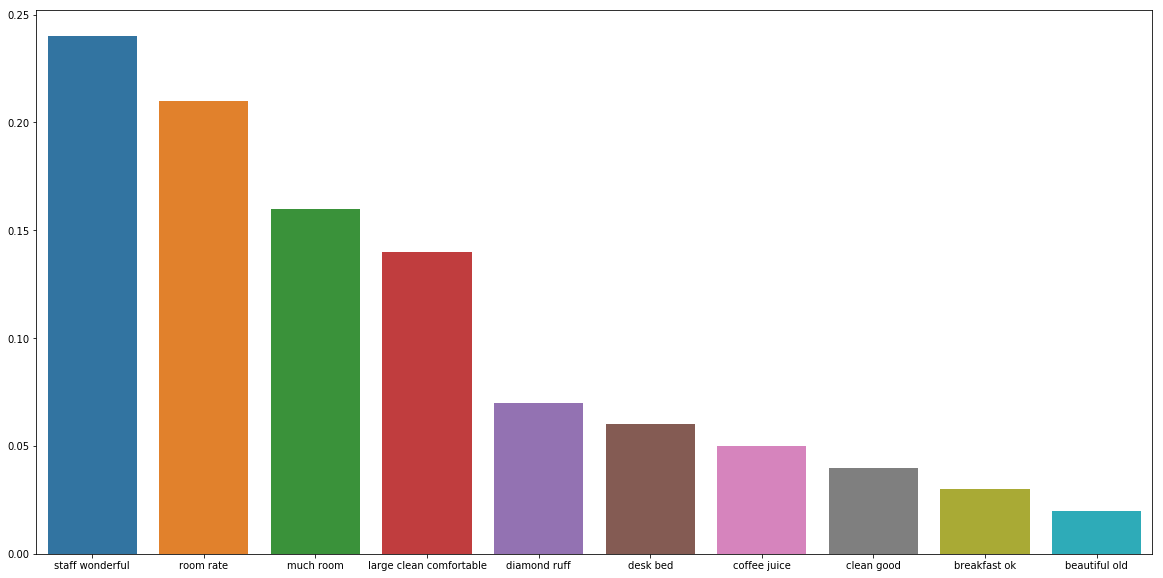

In [1661]:
plt.figure(figsize =(20, 10))
sns.barplot(pos_word, pos_freq)

In [1662]:
neg_freq = [phrase[0] for phrase in negative_phrases]
neg_freq =  np.round(neg_freq/sum(neg_freq),2)
neg_word = [phrase[1] for phrase in negative_phrases]

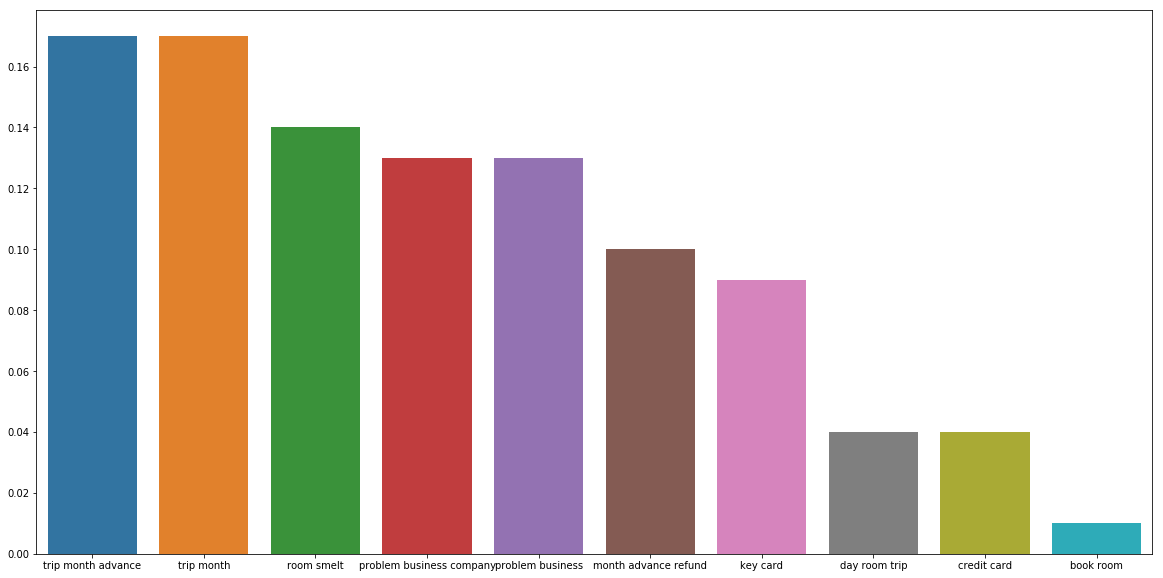

In [1663]:
plt.figure(figsize =(20, 10))
sns.barplot(neg_word, neg_freq)